<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Скользящие-средние" data-toc-modified-id="Скользящие-средние-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Скользящие средние</a></span></li><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Разделение-на-выборки" data-toc-modified-id="Разделение-на-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Разделение на выборки</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [2]:
# для анализа и работы с данными
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# модели ML
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import (train_test_split,
                                     TimeSeriesSplit,
                                     cross_val_score,
                                     GridSearchCV)
import warnings
warnings.filterwarnings("ignore")

# метрики для алгоритмов ML
from sklearn.metrics import (make_scorer,
                             mean_squared_error)

# константы
MAX_LAG = 84 
ROLLING_MEAN_SIZE = 24 
RANDOM_STATE = 12345 

In [3]:
data=pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
# Созадим функцию для анализа таблиц
def analysis(data):
    print(100*'-')
    print('Общая информамия:')
    print(data.info())
    
    print(100*'-')
    print('Первые 5 строк')
    display(data.head(5))
    
    print(100*'-')
    print('Количество пропусков')
    print(data.isnull().sum())
    
    print(100*'-')
    print('Количество дубликатов:')
    display(data.duplicated().sum())
    
    print(100*'-')
    print('Статистические данные')
    display(data.describe())


In [5]:
analysis(data)

----------------------------------------------------------------------------------------------------
Общая информамия:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
----------------------------------------------------------------------------------------------------
Первые 5 строк


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


----------------------------------------------------------------------------------------------------
Количество пропусков
num_orders    0
dtype: int64
----------------------------------------------------------------------------------------------------
Количество дубликатов:


26415

----------------------------------------------------------------------------------------------------
Статистические данные


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Т.к. у нас в задаче стоит спрогнозировать загруженность такси на следующий час, а у нас в таблице интервал 10 минут - проведем ресемплирование.

In [6]:
data = data.resample('1H').sum()
# Проверка
data.shape

(4416, 1)

## Анализ

In [7]:
# Проверка хронологии дат
print(data.index.is_monotonic)

True


Построим общий график заказов от времени

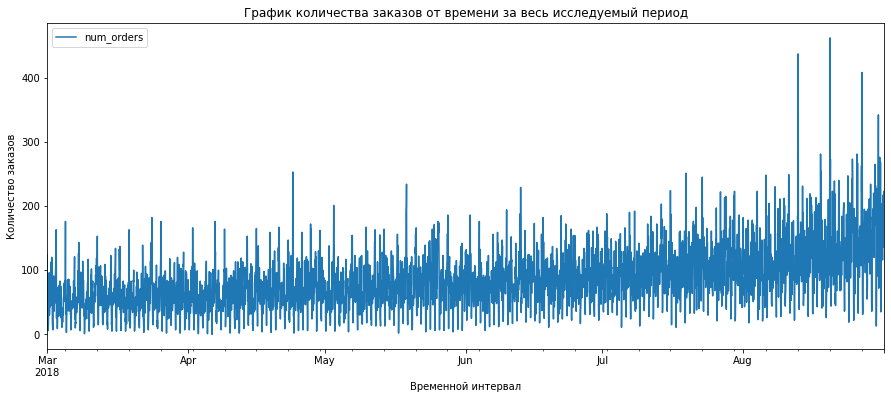

In [8]:
data.plot(figsize=(15, 6))
plt.legend()
plt.title('График количества заказов от времени за весь исследуемый период')
plt.xlabel('Временной интервал')
plt.ylabel('Количество заказов')
plt.show;

Из графика видно, что у нас имееются всплески по количеству заказов. Для большей наглядности возьмем меньший промежуток в недели.

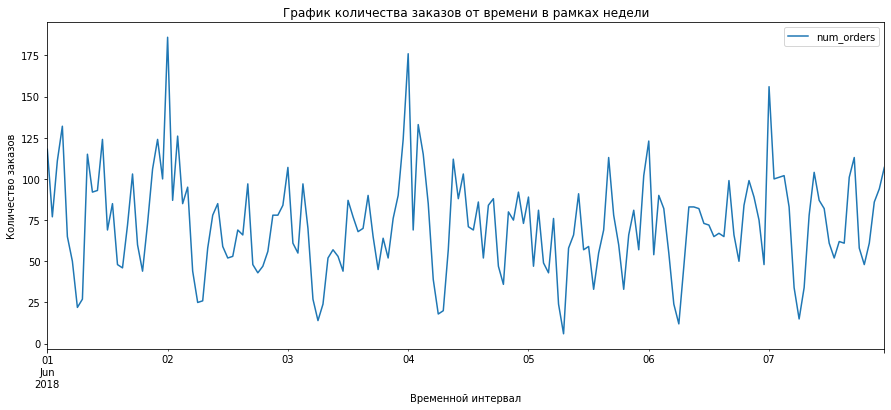

In [9]:
data['2018-06-1':'2018-06-7'].plot(figsize=(15, 6))
plt.legend()
plt.title('График количества заказов от времени в рамках недели')
plt.xlabel('Временной интервал')
plt.ylabel('Количество заказов')
plt.show;

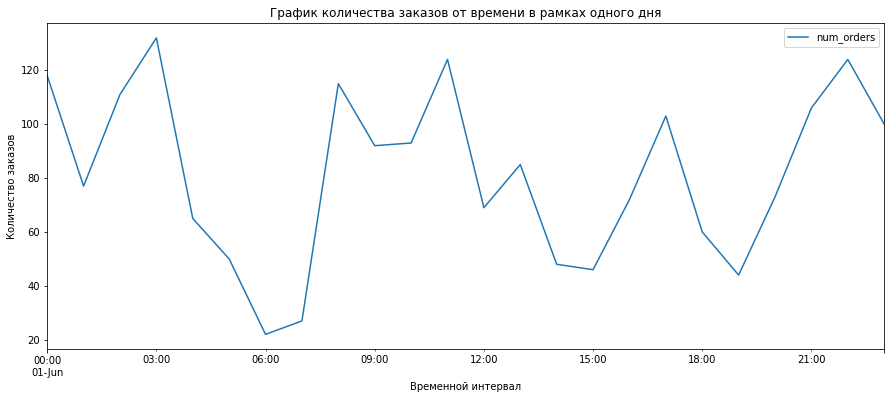

In [10]:
data['2018-06-1':'2018-06-1'].plot(figsize=(15, 6))
plt.legend()
plt.title('График количества заказов от времени в рамках одного дня')
plt.xlabel('Временной интервал')
plt.ylabel('Количество заказов')
plt.show;

### Скользящие средние

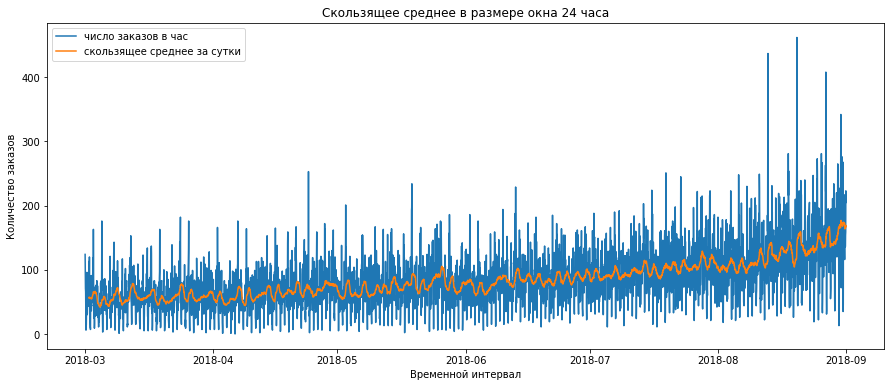

In [11]:
plt.figure(figsize=(15, 6))
plt.plot(data, label = 'число заказов в час')
plt.plot(data.rolling(24).mean(), label = 'скользящее среднее за сутки')

plt.legend()
plt.title('Скользящее среднее в размере окна 24 часа')
plt.xlabel('Временной интервал')
plt.ylabel('Количество заказов')
plt.show;

### Тренды и сезонность

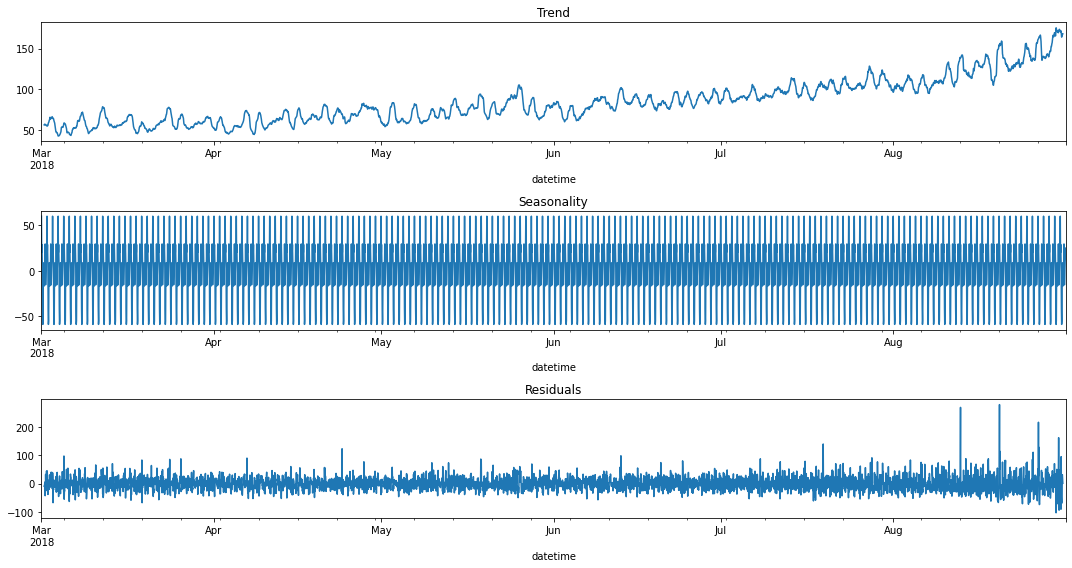

In [12]:
decomposed = seasonal_decompose(data) 

plt.figure(figsize=(15, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Из-за большого временного интервала тяжело анализировать данные графики, поэтому возьмем также недельный интервал времени.

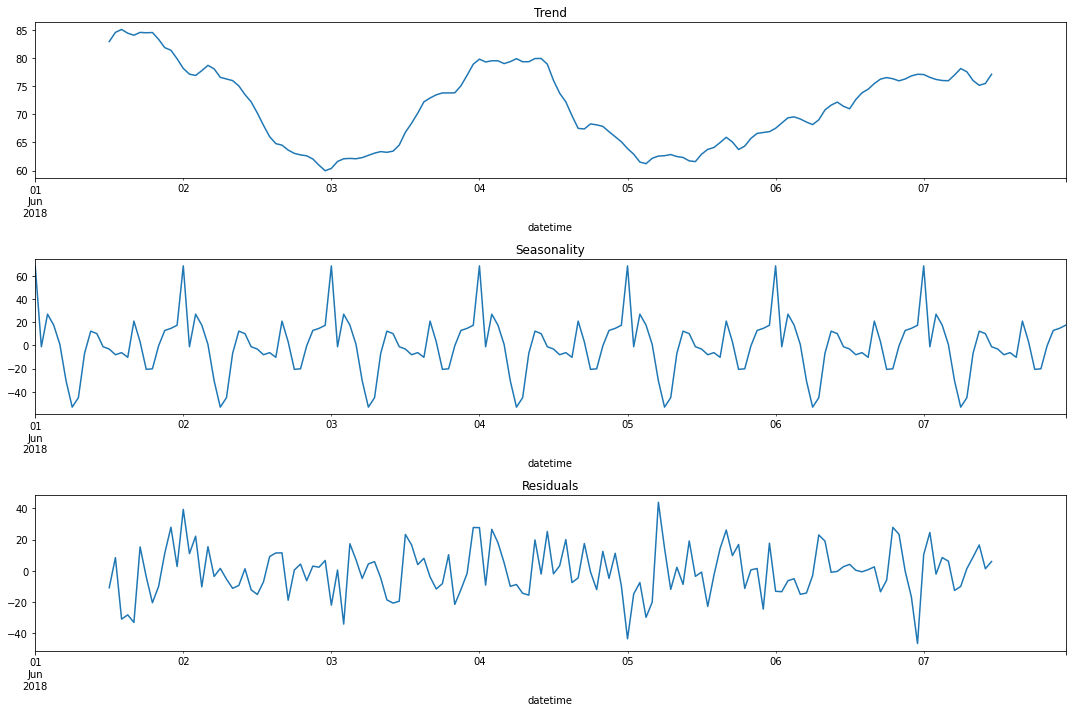

In [13]:
decomposed = seasonal_decompose(data['2018-06-1':'2018-06-7']) 

plt.figure(figsize=(15, 10))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

### Вывод

Если обратить внимания на график скользящего среднего можно увидеть растущий тренд заказов такси на всем временном интервале. Если рассматривать тренд в течение недели и одного дня можно увидеть неравномерность заказов от времени. Наибольшие значения заказов можно наблюдать именной ночью, наименьшее количество соответвует раннему утру - приблизительно в 6 утра.

## Обучение

### Создание признаков

Напишем функцию для создания признаков. Разберём каждый тип признаков:
1. Календарные признаки (англ. calendar features)
Во многих данных тренды и сезонность привязаны к конкретной дате. Тип datetime64 в Pandas уже содержит нужную информацию, осталось лишь представить её как отдельные столбцы.
2. «Отстающие значения» (англ. lag features)
Предыдущие значения временного ряда подскажут, будет ли функция x(t) расти или уменьшаться. 
3. Скользящее среднее
Скользящее среднее как признак задаёт общий тренд временного ряда.

In [14]:
# сброс сезонности
data = data.resample('1H').sum()

In [15]:
def make_features(data, column, MAX_LAG, ROLLING_MEAN_SIZE):
    data['dayofweek'] = data.index.dayofweek
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    
    for lag in range(1, MAX_LAG + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(ROLLING_MEAN_SIZE).mean()
    return data

In [16]:
make_features(data, 'num_orders',  MAX_LAG, ROLLING_MEAN_SIZE)

,num_orders,dayofweek,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_76,lag_77,lag_78,lag_79,lag_80,lag_81,lag_82,lag_83,lag_84,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,31,19,207.0,217.0,197.0,116.0,133.0,166.0,...,184.0,134.0,113.0,131.0,141.0,183.0,195.0,159.0,71.0,164.875000
2018-08-31 20:00:00,154,4,31,20,136.0,207.0,217.0,197.0,116.0,133.0,...,148.0,184.0,134.0,113.0,131.0,141.0,183.0,195.0,159.0,167.541667
2018-08-31 21:00:00,159,4,31,21,154.0,136.0,207.0,217.0,197.0,116.0,...,211.0,148.0,184.0,134.0,113.0,131.0,141.0,183.0,195.0,168.041667


In [17]:
# удалим пропуски
data = data.dropna()

### Разделение на выборки

In [18]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

print("Размер features_train", features_train.shape)
print("Размер features_test", features_test.shape)
print("Размер target_train", target_train.shape)
print("Размер target_test", target_test.shape)

Размер features_train (3898, 88)
Размер features_test (434, 88)
Размер target_train (3898,)
Размер target_test (434,)


In [19]:
# списки категориальных cat_col и числовых признаков num_col 
cat_col = ['dayofweek', 'day', 'hour']
num_col = data.columns[4:].to_list()

In [20]:
# закодируем данные через OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='ignore')

encoder.fit(features_train[cat_col])

features_train[cat_col] = encoder.transform(features_train[cat_col])
features_test[cat_col] = encoder.transform(features_test[cat_col])

### LinearRegression

In [21]:
tscv = TimeSeriesSplit(n_splits=5)
model_LR = LinearRegression() 
model_LR.fit(features_train, target_train)
score_LR = cross_val_score(model_LR, features_train, target_train, scoring='neg_mean_squared_error', cv=tscv)

print('Качество модели LinearRegression на кросс-валидации:',np.mean(-score_LR)**0.5)

Качество модели LinearRegression на кросс-валидации: 24.43369033656015


###  RandomForestRegressor

In [22]:
# Функция для подсчета RMSE
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
RMSE_score = make_scorer(RMSE, greater_is_better=False)

In [26]:
tscv = TimeSeriesSplit(n_splits=5)

model_RF = RandomForestRegressor()

# набор параметров для леса
parametrs_RF = { 'n_estimators': range(5, 15, 5),
                     'max_depth': range(1, 5, 2),
                     'min_samples_leaf': range(1, 5),
                     'min_samples_split': range(2, 8, 2) }

# подбор оптимальных параметров с помощью GridSearchCV 
model_RF_grid = GridSearchCV(model_RF, parametrs_RF, scoring=RMSE_score, cv=tscv)
model_RF_grid.fit(features_train, target_train)

best_params_RF = model_RF_grid.best_params_
score_RF = -model_RF_grid.best_score_
print('Параметры лучшей модели', best_params_RF)

print('RMSE модели RandomForestRegressor на кросс-валидации:', score_RF)

Параметры лучшей модели {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 10}
RMSE модели RandomForestRegressor на кросс-валидации: 27.438951344630595


### CatBoostRegressor

In [24]:
tscv = TimeSeriesSplit(n_splits=5)

model_CB = CatBoostRegressor()

# набор параметров для CatBoostRegressor
parametrs_CB = {'learning_rate': [0.1, 0.01],
                'depth': [3, 5, 7]}

# подбор оптимальных параметров с помощью GridSearchCV
model_CB_grid = GridSearchCV(model_CB, parametrs_CB, scoring=RMSE_score, cv=tscv)
model_CB_grid.fit(features_train, target_train, verbose=False)

best_params_CB = model_CB_grid.best_params_
score_CB = -model_CB_grid.best_score_

print('Параметры лучшей модели', best_params_CB)

print('RMSE модели CatBoostRegressor на кросс-валидации:', score_CB)

Параметры лучшей модели {'depth': 5, 'learning_rate': 0.1}
RMSE модели CatBoostRegressor на кросс-валидации: 23.504087974854748


Соберем все метрики качеств моделей в одном месте

In [28]:
print('RMSE модели LinearRegression на кросс-валидации:', np.mean(-score_LR)**0.5)
print('RMSE модели RandomForestRegressor на кросс-валидации:', score_RF)
print('RMSE модели CatBoostRegressor на кросс-валидации:', score_CB)

RMSE модели LinearRegression на кросс-валидации: 24.43369033656015
RMSE модели RandomForestRegressor на кросс-валидации: 27.438951344630595
RMSE модели CatBoostRegressor на кросс-валидации: 23.504087974854748


**Вывод:** Были созданы признаки,а также произведена их разбивка на обучающую и тестовую выборку. Была расмотрено три модели для каждой из которой был произведен подбор гиперпараметров. Лучший показатель метрики у модели Линейной регрессии, на втором месте идет CatBoostRegressor и замыкает тройку модель случайного леса.

## Тестирование

Для каждой модели проведем проверку на тестовой выборке.

In [29]:
predictions_LR= model_LR.predict(features_test)
print('RMSE модели LinearRegression на тестовой выборке', mean_squared_error(target_test, predictions_LR) ** 0.5)

RMSE модели LinearRegression на тестовой выборке 41.192655978820774


**Вывод:** После проверки модели на тестовой выборке мы получили метрику RMSE в пределах нашего задания, также можно отметить скорость обучения и предсказания модели. Поэтому для задач данного кейса пойдет модель Линейной регрессии.